In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



e:\User\PC\ads_enefit_ueh\ads_enfit


In [2]:
from libs.common import *
from config.config import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


e:/User/PC/ads_enefit_ueh/ads_enfit


In [3]:
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [4]:
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [5]:
# wandb.init(project="enefit_prediction_consumer")


In [6]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
scaler_y=joblib.load(f'{save_dir}/scaler_y.pkl')
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))
target_valid=pd.read_csv(f'{save_dir}/target_valid{ndays}_pre_processing.csv', index_col=None)
target_valid.drop(columns=['Unnamed: 0'], inplace=True)


In [7]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1086844, 102) (1086844, 1) (535312, 102) (535312, 1)


In [8]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


lr = 0.0001


features = len(X_train.columns)



# Khởi tạo mô hình Sequential
model = Sequential()

model.add(Conv1D(32, 3, activation='selu', input_shape=(features, 1)))

model.add(MaxPooling1D(2))

model.add(Flatten())

model.add(Dense(1024, activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='selu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='linear'))



# Compile the model
model.compile(optimizer=Adam(learning_rate=lr), loss='mae', metrics=['mae',r2])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 1024)              1639424   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                        

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_cnn.weigths.h5',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    mode='min',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1,  # Hiển thị thông báo khi lưu model
    save_format="tf"
)

In [11]:
model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[early_stopping,lr_scheduler,checkpoint_callback])

Epoch 1/10000
16981/16982 [============================>.] - ETA: 0s - loss: 1.3083 - mae: 1.3083 - r2: -136.2028
Epoch 1: val_loss improved from inf to 0.16471, saving model to best_model_cnn.weigths.h5
16982/16982 [==============================] - 569s 33ms/step - loss: 1.3082 - mae: 1.3082 - r2: -136.1947 - val_loss: 0.1647 - val_mae: 0.1647 - val_r2: 0.6504 - lr: 1.0000e-04
Epoch 2/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.1371 - mae: 0.1371 - r2: 0.6649
Epoch 2: val_loss improved from 0.16471 to 0.14396, saving model to best_model_cnn.weigths.h5
16982/16982 [==============================] - 1017s 60ms/step - loss: 0.1371 - mae: 0.1371 - r2: 0.6649 - val_loss: 0.1440 - val_mae: 0.1440 - val_r2: 0.7236 - lr: 1.0000e-04
Epoch 3/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.1324 - mae: 0.1324 - r2: 0.6828
Epoch 3: val_loss improved from 0.14396 to 0.14039, saving model to best_model_cnn.weigths.h5
16982/16982 [===================

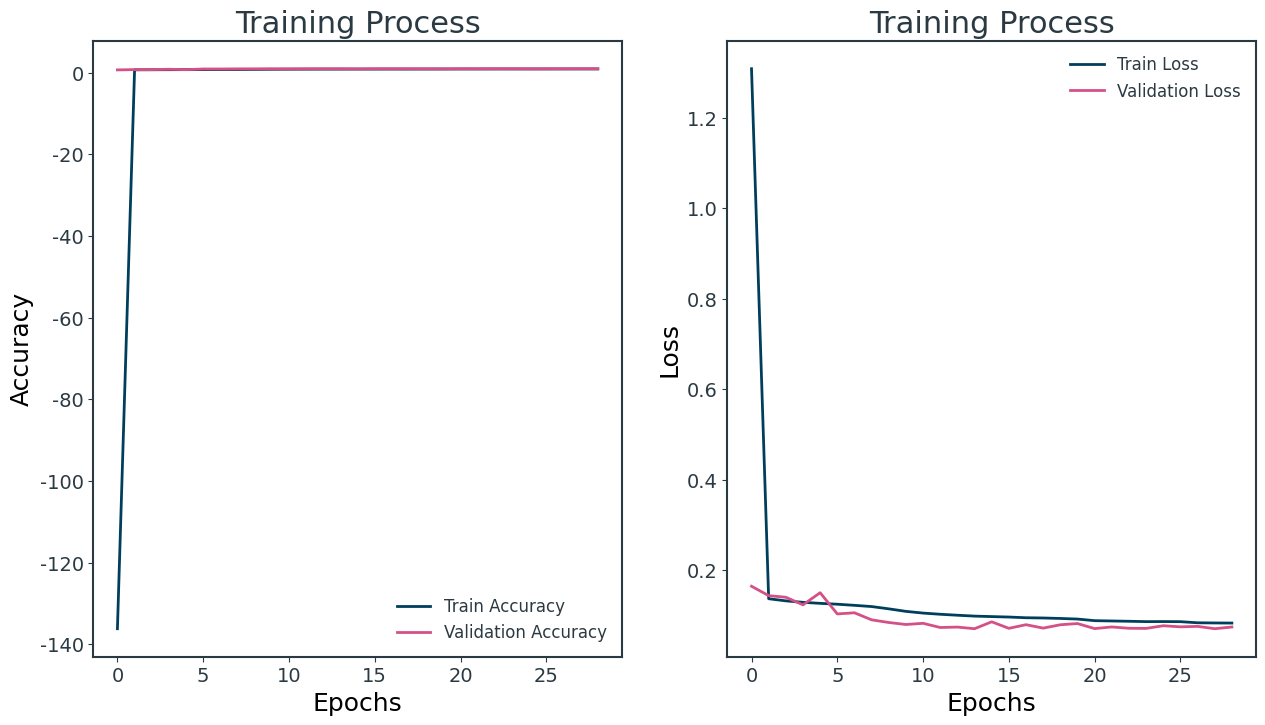

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

history = model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [13]:
model.history.history['r2']

[-136.19471740722656,
 0.6649308204650879,
 0.6827682852745056,
 0.7008774280548096,
 0.7134076952934265,
 0.7224089503288269,
 0.7363485097885132,
 0.7450631856918335,
 0.7696851491928101,
 0.7973421216011047,
 0.816106379032135,
 0.8249849081039429,
 0.8341724276542664,
 0.8372201919555664,
 0.8420946598052979,
 0.8439414501190186,
 0.8475525379180908,
 0.8474702835083008,
 0.8515320420265198,
 0.8564817905426025,
 0.8652883768081665,
 0.8668932914733887,
 0.8703515529632568,
 0.871644139289856,
 0.87166428565979,
 0.8716916441917419,
 0.8799025416374207,
 0.8790289759635925,
 0.880945086479187]

In [14]:
# Truy cập vào lịch sử của mô hình
training_history = model.history.history

# In ra các keys của lịch sử
print(training_history.keys())

# In ra các giá trị của loss và accuracy qua các epochs
print(training_history['loss'])
print(training_history['val_loss'])

dict_keys(['loss', 'mae', 'r2', 'val_loss', 'val_mae', 'val_r2', 'lr'])
[1.3082106113433838, 0.13711042702198029, 0.1323951631784439, 0.12919707596302032, 0.1269277036190033, 0.12498942017555237, 0.12253030389547348, 0.11983869224786758, 0.11479410529136658, 0.10920967161655426, 0.10541652888059616, 0.10278867185115814, 0.10067436099052429, 0.09873029589653015, 0.09767424315214157, 0.09665941447019577, 0.0951065719127655, 0.09457851201295853, 0.09353497624397278, 0.09221919625997543, 0.08866377174854279, 0.08799997717142105, 0.08731231093406677, 0.08654239028692245, 0.08666867017745972, 0.08643613755702972, 0.08397819101810455, 0.08358684927225113, 0.08338186144828796]
[0.16470757126808167, 0.1439594030380249, 0.14039330184459686, 0.1236233189702034, 0.15041722357273102, 0.10354825854301453, 0.10609196871519089, 0.09049075841903687, 0.08460278064012527, 0.08017495274543762, 0.08282475918531418, 0.07355654984712601, 0.07446683198213577, 0.07088340818881989, 0.08611853420734406, 0.071727

In [15]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = model.predict(X_valid)

# Tính toán R2 Score
r2 = r2_score(y_valid, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_valid, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")


16729/16729 [==============================] - 91s 5ms/step
R2 Score: 0.9458895706699695
MAE: 0.07088331570427586
